<a href="https://colab.research.google.com/github/Mohamad-Alshalabi/Coursera_Capstone/blob/master/The%20battle%20of%20neighborhoods%20week2%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**THE BATTLE OF NEIGHBORHOODS**



#**Introduction**



Stockholm is the capital and most populous urban area of Sweden as well as in Scandinavia. Around 1 million people live in the municipality, approximately 1.6 million in the urban area, and 2.4 million in the metropolitan area. The city stretches across fourteen islands and it's one of the five fastest-growing cities in Europe.


Geographically, Stockholm city area only covers 188 squared kilometers; the area stretches to 6,519 squared kilometers for the metropolitan area. The disparity between the city center's density and the metropolitan area is more than ten folds, where the density within the city center is 5200 per sqr/km, the density in the metropolitan area is only 370 per sqr/km.
There are more than 3000 restaurants in Stockholm. The biggest food retailers in Sweden collectively have around 460 stores in Stockholm.



##**Problem**


The food supply in Stockholm metropolitan area concentrates mainly within the center, while the peripheries have less coverage. Opening a new food venue might be more profitable if the new establishments locate in areas with higher food demand. To tackle this problem we need to estimate the food demand in each neighborhood.
1.	Define Stockholm's neighborhoods
2.	Estimate the food demand in each neighborhood 




#**Target market** 


This study can benefit both food retailers and new investors in the food and beverage market in Stockholm, pointing out the regions with the least food coverage can open the path for various investment opportunities.  

#**Data**

**The data is obtained from various sources. The issue of data availability is overcome by creating our own sources.** 
  
To answer the question of which neighborhood in Stockholm has the least coverage of food venues, we should look into two main variables: the number of venues in each neighborhood. The Second variable is concerning the number of inhabitants in the neighborhood. 
In the list below I include the three source of data used in this study.     
1. The name and the postal code for each neighborhood collected and scrapped from the following website: https://worldpostalcode.com
2. The Latitude, the Longitude and the Population for each neighborhood in stockholm manually collected and gathered in one CSV file.
3. Name, location, latitude, longitude for each food venue in the neighborhoods collected from https://api.foursquare.com website. 


In [1]:
!pip install geocoder
!pip install folium
import numpy as np 
import pandas as pd 
import geocoder 
import requests 
from requests import get 
from bs4 import BeautifulSoup 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
print("Importing is done")

Importing is done


In [2]:
url = "https://worldpostalcode.com/sweden/stockholm/"
response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [3]:
Stockholm_containers = html_soup.find_all('div', class_ = 'container')
print(type(Stockholm_containers))
print(len(Stockholm_containers))

<class 'bs4.element.ResultSet'>
64


In [4]:
names = []
for container in Stockholm_containers:
    if container.find('div') is not None:
        name = container.div.text
    names.append(name)

In [5]:
Stockholm_codes = html_soup.find_all( class_ = 'code')
codes = []
for code in Stockholm_codes :
    i = Stockholm_codes.index(code)
    code = str(code)
    code = code.replace('<div class="code"><span>', '')
    code = code.replace('</span></div>', '')    
    code = code.split('</span> <span>') 
    codes.append(code)

In [6]:
data = {'Neighborhood': names, 'Postal_Code': codes}
Data= pd.DataFrame(data= data, columns= ['Neighborhood','Postal_Code'])

In [7]:
Stockholm_data = pd.read_csv("https://raw.githubusercontent.com/Mohamad-Alshalabi/Coursera_Capstone/master/Book2.csv")

Stockholm_data.head()

,Neighborhood,Latitude,Longitude,Population
0,Akersberga,59.4803,18.3108,28033
1,Alta,59.2555,18.1781,9989
2,Alvsjo,59.2745,18.0051,1530
3,Arsta,59.2986,18.0459,16807
4,Bagarmossen,59.2744,18.1338,10915


In [8]:
Stockholm_geo_data = pd.merge(Stockholm_data, Data, on='Neighborhood')
Stockholm_geo_data.head()

,Neighborhood,Latitude,Longitude,Population,Postal_Code
0,Akersberga,59.4803,18.3108,28033,[184 20]
1,Alta,59.2555,18.1781,9989,[138 20]
2,Alvsjo,59.2745,18.0051,1530,"[125 00, 125 58, 125 52, 125 53, 125 54, 125 5..."
3,Arsta,59.2986,18.0459,16807,"[120 02, 120 52, 120 59, 120 58, 120 57, 120 5..."
4,Bagarmossen,59.2744,18.1338,10915,"[128 04, 128 05, 128 41, 128 42, 128 43, 128 4..."


In [9]:
print('The dataframe has {} neighborhoods.'.format( len(Stockholm_geo_data['Neighborhood'].unique())))

The dataframe has 64 neighborhoods.


In [10]:
address = 'Stockholm Sweden'
geolocator = Nominatim(user_agent="stock_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stockholm are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholm are 59.3251172, 18.0710935.


In [11]:
map_Stockholm = folium.Map(location=[latitude,longitude], zoom_start= 10)
for lat, lng, label in zip(Stockholm_geo_data['Latitude'], Stockholm_geo_data['Longitude'], Stockholm_geo_data['Neighborhood']):
    label = folium.Popup(label, parse_html= True)
    folium.CircleMarker(
        [lat,lng],
        radius=6,
        popup= label, 
        color= 'blue',
        fill= True,
        fill_color= 'FFFF5c', 
        fill_opacity= 0.7
        ).add_to(map_Stockholm)

map_Stockholm

In [12]:
CLIENT_ID = 'CAH33GB3T5AA33ZLAPKRSPMN0HPJAF0CRI1ES31CMFKIMRT0' 
CLIENT_SECRET = 'Q1LRHG2SDJMSACGJGKA1K2CMDWGMPJQSN05CWAMEOOEFH0YL' 
VERSION = '20210217'

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, categoryIds=''):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
       
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
      
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
                  

In [14]:
Stockholm_food_venues = getNearbyVenues(names=Stockholm_geo_data['Neighborhood'],
                                   latitudes=Stockholm_geo_data['Latitude'],
                                   longitudes=Stockholm_geo_data['Longitude'], radius=1000, categoryIds= '4d4b7105d754a06374d81259')

Akersberga
Alta
Alvsjo
Arsta
Bagarmossen
Bandhagen
Bro
Bromma
Danderyd
Ekero
Enskede
Enskede Gard
Enskededalen
Farsta
Gustavsberg
Hagersten
Hallstavik
Handen
Haninge
Hasselby
Huddinge
Jarfalla
Jarna
Johanneshov
Kista
Kungsangen
Lidingo
Marsta
Nacka
Norrtalje
Norsborg
Nykvarn
Nynashamn
Osmo
Rimbo
Ronninge
Rosersberg
Saltsjo-Boo
Saltsjobaden
Sigtuna
Skarholmen
Skarpnack
Skogas
Skondal
Sodertalje
Sollentuna
Solna
Spanga
Stockholm
Stockholm-Arlanda
Stockholm-Globen
Sundbyberg
Taby
Tomteboda
Tullinge
Tumba
Tyreso
Upplands Vasby
Vallentuna
Vallingby
Varby
Varmdo
Vasterhaninge
Vaxholm


In [15]:
Stockholm_food_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Akersberga,59.4803,18.3108,ICA Kvantum Åkersberga,59.479721,18.297570,Grocery Store
1,Akersberga,59.4803,18.3108,Berga Sushi,59.482627,18.302635,Sushi Restaurant
2,Akersberga,59.4803,18.3108,The Public,59.480178,18.298988,Gastropub
3,Akersberga,59.4803,18.3108,Åkersberga (L),59.479164,18.299074,Light Rail Station
4,Akersberga,59.4803,18.3108,Apotek Hjärtat,59.479528,18.300780,Pharmacy


In [16]:
Stockholm_food_venues.shape

(1311, 7)

In [17]:
Stockholm_food_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Akersberga,12,12,12,12,12,12
Alta,9,9,9,9,9,9
Alvsjo,26,26,26,26,26,26
Arsta,37,37,37,37,37,37
Bagarmossen,21,21,21,21,21,21
...,...,...,...,...,...,...
Vallingby,33,33,33,33,33,33
Varby,9,9,9,9,9,9
Varmdo,3,3,3,3,3,3


In [18]:
print('There are {} uniques categories.'.format(len(Stockholm_food_venues['Venue Category'].unique())))

There are 208 uniques categories.


In [19]:
Stockholm_onehot = pd.get_dummies(Stockholm_food_venues[['Venue Category']], prefix="", prefix_sep="")
Stockholm_onehot['Neighborhood'] = Stockholm_food_venues['Neighborhood'] 
fixed_columns = [Stockholm_onehot.columns[-1]] + list(Stockholm_onehot.columns[:-1])
Stockholm_onehot = Stockholm_onehot[fixed_columns]
Stockholm_onehot.head()

,Women's Store,Airport,Airport Lounge,Airport Service,American Restaurant,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Border Crossing,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal Lock,...,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Soccer Stadium,South Indian Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
Stockholm_onehot.shape

(1311, 208)

In [21]:
Stockholm_grouped = Stockholm_onehot.groupby('Neighborhood').mean().reset_index()
Stockholm_grouped

,Neighborhood,Women's Store,Airport,Airport Lounge,Airport Service,American Restaurant,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Border Crossing,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,...,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Soccer Stadium,South Indian Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar
0,Akersberga,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.083333,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.083333,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Alta,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.111111,0.0,0.0,0.0,0.111111,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.111111,0.0,0.0,0.000000,0.0,0.0,0.111111,0.000000,0.111111,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Alvsjo,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.038462,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.038462,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.038462,0.0,0.000000,0.0,0.038462,0.0,0.0,0.000000,0.0,0.0,0.000000,0.038462,0.076923,0.038462,0.0,0.0,0.0,0.0,0.000000,0.038462,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.038462,0.0,0.0,0.0,0.0,0.0,0.0
3,Arsta,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.054054,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.027027,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.027027,0.0,0.000000,0.0,0.0,0.027027,0.027027,0.0,0.0,0.0,0.054054,0.0,0.0,...,0.0,0.027027,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.054054,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.027027,0.027027,0.0,0.0,0.0,0.0,0.0,0.000000,0.027027,0.0,0.0,0.0,0.0,0.0,0.0
4,Bagarmossen,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.047619,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.095238,0.047619,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Vallingby,0.0,0.0,0.0,0.0,0.030303,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.030303,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.030303,0.0,0.0,0.0

In [22]:
num_top_venues = 5

for hood in Stockholm_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Stockholm_grouped[Stockholm_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Akersberga----
                venue  freq
0  Chinese Restaurant  0.08
1  Athletics & Sports  0.08
2         Pizza Place  0.08
3           Gastropub  0.08
4                Café  0.08


----Alta----
                  venue  freq
0              Bus Stop  0.11
1  Arts & Entertainment  0.11
2          Soccer Field  0.11
3         Shopping Mall  0.11
4           Supermarket  0.11


----Alvsjo----
               venue  freq
0              Hotel  0.15
1        Supermarket  0.08
2  Convenience Store  0.04
3             Bakery  0.04
4               Café  0.04


----Arsta----
                venue  freq
0                Park  0.05
1         Pizza Place  0.05
2       Grocery Store  0.05
3  Light Rail Station  0.05
4    Asian Restaurant  0.05


----Bagarmossen----
                  venue  freq
0           Pizza Place  0.19
1         Metro Station  0.10
2         Grocery Store  0.10
3           Supermarket  0.10
4  Fast Food Restaurant  0.10


----Bandhagen----
                  venue  freq
0  

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Stockholm_grouped['Neighborhood']

for ind in np.arange(Stockholm_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Stockholm_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akersberga,Pharmacy,Light Rail Station,Sushi Restaurant,Liquor Store,Café,Chinese Restaurant,Grocery Store,Athletics & Sports,Gastropub,Forest
1,Alta,Hockey Arena,Arts & Entertainment,Shopping Mall,Stadium,Supermarket,Bus Stop,Café,Soccer Field,Convenience Store,Design Studio
2,Alvsjo,Hotel,Supermarket,Coffee Shop,Tennis Stadium,Restaurant,Shopping Mall,Café,Soccer Field,Forest,Pizza Place
3,Arsta,Café,Park,Pizza Place,Light Rail Station,Soccer Field,Flower Shop,Asian Restaurant,Grocery Store,Convenience Store,Bus Station
4,Bagarmossen,Pizza Place,Park,Metro Station,Supermarket,Grocery Store,Fast Food Restaurant,Other Great Outdoors,Plaza,Japanese Restaurant,Pub
5,Bandhagen,Burger Joint,Gym / Fitness Center,Sushi Restaurant,Grocery Store,Café,Scandinavian Restaurant,Playground,Pizza Place,Bus Station,Hobby Shop
6,Bro,Pizza Place,Convenience Store,Train Station,Bus Station,Gym Pool,Grocery Store,Wine Bar,Eastern European Restaurant,Fish Market,Field
7,Bromma,Fast Food Restaurant,Pizza Place,Metro Station,Soccer Field,Supermarket,Sushi Restaurant,Garden Center,Food & Drink Shop,Liquor Store,Sporting Goods Shop
8,Danderyd,Pizza Place,Hotel,Hobby Shop,Bus Station,Gym / Fitness Center,Furniture / Home Store,Grocery Store,Supermarket,Scandinavian Restaurant,Eastern European Restaurant
9,Ekero,Pizza Place,Restaurant,Convenience Store,Stadium,Gym / Fitness Center,Grocery Store,Discount Store,Field,Fast Food Restaurant,Farmers Market


In [25]:
Stockholm_grouped_clustring= Stockholm_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Stockholm_grouped_clustring)
    Sum_of_squared_distances.append(km.inertia_)

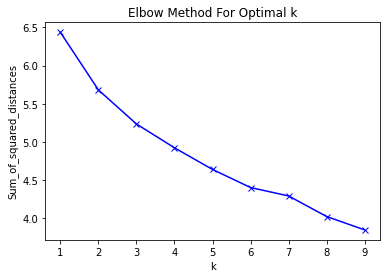

In [26]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [27]:
kclusters = 7
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Stockholm_grouped_clustring)
kmeans.labels_[0:10]

array([2, 2, 2, 2, 1, 1, 4, 2, 1, 1], dtype=int32)

In [28]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Stockholm_merged = Stockholm_geo_data

Stockholm_merged = Stockholm_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Stockholm_merged.drop([16], inplace=True)
Stockholm_merged.reset_index()

Stockholm_merged

,Neighborhood,Latitude,Longitude,Population,Postal_Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akersberga,59.4803,18.3108,28033,[184 20],2,Pharmacy,Light Rail Station,Sushi Restaurant,Liquor Store,Café,Chinese Restaurant,Grocery Store,Athletics & Sports,Gastropub,Forest
1,Alta,59.2555,18.1781,9989,[138 20],2,Hockey Arena,Arts & Entertainment,Shopping Mall,Stadium,Supermarket,Bus Stop,Café,Soccer Field,Convenience Store,Design Studio
2,Alvsjo,59.2745,18.0051,1530,"[125 00, 125 58, 125 52, 125 53, 125 54, 125 5...",2,Hotel,Supermarket,Coffee Shop,Tennis Stadium,Restaurant,Shopping Mall,Café,Soccer Field,Forest,Pizza Place
3,Arsta,59.2986,18.0459,16807,"[120 02, 120 52, 120 59, 120 58, 120 57, 120 5...",2,Café,Park,Pizza Place,Light Rail Station,Soccer Field,Flower Shop,Asian Restaurant,Grocery Store,Convenience Store,Bus Station
4,Bagarmossen,59.2744,18.1338,10915,"[128 04, 128 05, 128 41, 128 42, 128 43, 128 4...",1,Pizza Place,Park,Metro Station,Supermarket,Grocery Store,Fast Food Restaurant,Other Great Outdoors,Plaza,Japanese Restaurant,Pub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Vallingby,59.3671,17.8691,82500,"[162 00, 162 60, 162 01, 162 88, 162 83, 162 7...",2,Supermarket,Café,Gym / Fitness Center,Bookstore,Moving Target,Movie Theater,Food Court,Restaurant,Sporting Goods Shop,Hawaiian Restaurant
60,Varby,59.2635,17.8876,10727,"[143 46, 143 20]",4,Pizza Place,Convenience Store,Bus Station,Fast Food Restaurant,Gym Pool,Metro Station,Furniture / Home Store,Grocery Store,Brewery,Wine Bar
61,Varmdo,59.2846,18.5208,45393,"[139 00, 139 20, 139 31]",0,Tennis Court,Beach,Lake,Wine Bar,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farmers Market
62,Vasterhaninge,59.1216,18.0973,15134,"[137 20, 137 42]",5,Grocery Store,Restaurant,Chinese Restaurant,Café,Liquor Store,Bus Station,Supermarket,Train Station,Pizza Place,Stadium


In [29]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 0, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Huddinge,0,Lake,Beach,Electronics Store,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farmers Market
61,Varmdo,0,Tennis Court,Beach,Lake,Wine Bar,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant,Farmers Market


In [30]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 1, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]  

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bagarmossen,1,Pizza Place,Park,Metro Station,Supermarket,Grocery Store,Fast Food Restaurant,Other Great Outdoors,Plaza,Japanese Restaurant,Pub
5,Bandhagen,1,Burger Joint,Gym / Fitness Center,Sushi Restaurant,Grocery Store,Café,Scandinavian Restaurant,Playground,Pizza Place,Bus Station,Hobby Shop
8,Danderyd,1,Pizza Place,Hotel,Hobby Shop,Bus Station,Gym / Fitness Center,Furniture / Home Store,Grocery Store,Supermarket,Scandinavian Restaurant,Eastern European Restaurant
9,Ekero,1,Pizza Place,Restaurant,Convenience Store,Stadium,Gym / Fitness Center,Grocery Store,Discount Store,Field,Fast Food Restaurant,Farmers Market
10,Enskede,1,Hobby Shop,Bus Station,Pizza Place,Bus Stop,Supermarket,Grocery Store,Automotive Shop,Sushi Restaurant,Café,Event Space
12,Enskededalen,1,Grocery Store,Café,Cemetery,Bakery,Flower Shop,Pizza Place,Sushi Restaurant,Convenience Store,Fast Food Restaurant,Plaza
13,Farsta,1,Grocery Store,Bakery,Thai Restaurant,Plaza,Pizza Place,Shopping Plaza,Racetrack,Tennis Court,Restaurant,Farm
15,Hagersten,1,Metro Station,Grocery Store,Pizza Place,Café,Asian Restaurant,Scandinavian Restaurant,Campground,Forest,Fast Food Restaurant,Plaza
29,Norrtalje,1,Grocery Store,Café,Supermarket,Flower Shop,Liquor Store,River,Restaurant,Burger Joint,Pizza Place,Hotel
41,Skarpnack,1,Pizza Place,Gym,Fast Food Restaurant,Park,Bus Stop,Garden Center,Metro Station,Church,Supermarket,Japanese Restaurant


In [31]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 2, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akersberga,2,Pharmacy,Light Rail Station,Sushi Restaurant,Liquor Store,Café,Chinese Restaurant,Grocery Store,Athletics & Sports,Gastropub,Forest
1,Alta,2,Hockey Arena,Arts & Entertainment,Shopping Mall,Stadium,Supermarket,Bus Stop,Café,Soccer Field,Convenience Store,Design Studio
2,Alvsjo,2,Hotel,Supermarket,Coffee Shop,Tennis Stadium,Restaurant,Shopping Mall,Café,Soccer Field,Forest,Pizza Place
3,Arsta,2,Café,Park,Pizza Place,Light Rail Station,Soccer Field,Flower Shop,Asian Restaurant,Grocery Store,Convenience Store,Bus Station
7,Bromma,2,Fast Food Restaurant,Pizza Place,Metro Station,Soccer Field,Supermarket,Sushi Restaurant,Garden Center,Food & Drink Shop,Liquor Store,Sporting Goods Shop
11,Enskede Gard,2,Stadium,Thai Restaurant,Gym / Fitness Center,Bakery,Restaurant,Nightclub,Park,Climbing Gym,Bookstore,Light Rail Station
14,Gustavsberg,2,Flower Shop,Furniture / Home Store,Department Store,Shopping Mall,Bus Stop,Electronics Store,Flea Market,Fish Market,Field,Fast Food Restaurant
17,Handen,2,Bus Station,Clothing Store,Middle Eastern Restaurant,Hotel,Coffee Shop,Shopping Mall,Mexican Restaurant,Gym / Fitness Center,Lake,Grocery Store
18,Haninge,2,Supermarket,Burger Joint,Fast Food Restaurant,Department Store,Pharmacy,Automotive Shop,Shopping Mall,Bowling Alley,Furniture / Home Store,Liquor Store
19,Hasselby,2,Café,Grocery Store,Supermarket,Gym / Fitness Center,Playground,Bookstore,Plaza,Food Court,Pool,Movie Theater


In [32]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 3, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]  

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Saltsjo-Boo,3,Boat or Ferry,Bus Stop,Golf Course,Wine Bar,Event Space,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant


In [33]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 4, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Bro,4,Pizza Place,Convenience Store,Train Station,Bus Station,Gym Pool,Grocery Store,Wine Bar,Eastern European Restaurant,Fish Market,Field
30,Norsborg,4,Bus Station,Convenience Store,Fast Food Restaurant,Pizza Place,Shopping Mall,Grocery Store,Theater,Athletics & Sports,Supermarket,Community Center
35,Ronninge,4,Plaza,Train Station,Grocery Store,Bus Station,Bar,Pizza Place,Convenience Store,Field,Eastern European Restaurant,Fast Food Restaurant
60,Varby,4,Pizza Place,Convenience Store,Bus Station,Fast Food Restaurant,Gym Pool,Metro Station,Furniture / Home Store,Grocery Store,Brewery,Wine Bar


In [34]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 5, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Jarna,5,Coffee Shop,Pizza Place,Train Station,Supermarket,Grocery Store,Music Venue,Wine Bar,Duty-free Shop,Field,Fast Food Restaurant
28,Nacka,5,Lake,Hobby Shop,Bus Stop,Grocery Store,Eastern European Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farmers Market
31,Nykvarn,5,Food & Drink Shop,Train Station,Construction & Landscaping,Park,Bus Station,Grocery Store,Pharmacy,Hardware Store,Diner,Health & Beauty Service
33,Osmo,5,Burger Joint,Bus Station,Train Station,Gym Pool,Bath House,Grocery Store,Soccer Field,Wine Bar,Event Space,Flea Market
42,Skogas,5,Grocery Store,Coffee Shop,Soccer Field,Bus Station,Fountain,Liquor Store,Tennis Court,Train Station,Pizza Place,Convention Center
56,Tyreso,5,Grocery Store,Bus Station,Bus Stop,Italian Restaurant,Eastern European Restaurant,Flea Market,Fish Market,Field,Fast Food Restaurant,Farmers Market
62,Vasterhaninge,5,Grocery Store,Restaurant,Chinese Restaurant,Café,Liquor Store,Bus Station,Supermarket,Train Station,Pizza Place,Stadium


In [35]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 6, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [36]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [37]:
map_Stockholm_food_venues = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(Stockholm_food_venues, 'red', map_Stockholm_food_venues)

map_Stockholm_food_venues

In [38]:
Stockholm_grouped_1=  Stockholm_food_venues.groupby('Neighborhood').count()
Stockholm_grouped_1.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Akersberga,12,12,12,12,12,12
Alta,9,9,9,9,9,9
Alvsjo,26,26,26,26,26,26
Arsta,37,37,37,37,37,37
Bagarmossen,21,21,21,21,21,21


In [39]:
Stockholm_grouped_1.shape

(64, 6)

In [40]:
Data_1= pd.DataFrame(data=Stockholm_grouped_1, columns=['Venue'] )
Data_1

,Venue
Neighborhood,
Akersberga,12
Alta,9
Alvsjo,26
Arsta,37
Bagarmossen,21
...,...
Vallingby,33
Varby,9
Varmdo,3


In [41]:
Stockholm= pd.merge(Stockholm_geo_data , Data_1, on='Neighborhood')

In [42]:
Stockholm

,Neighborhood,Latitude,Longitude,Population,Postal_Code,Venue
0,Akersberga,59.4803,18.3108,28033,[184 20],12
1,Alta,59.2555,18.1781,9989,[138 20],9
2,Alvsjo,59.2745,18.0051,1530,"[125 00, 125 58, 125 52, 125 53, 125 54, 125 5...",26
3,Arsta,59.2986,18.0459,16807,"[120 02, 120 52, 120 59, 120 58, 120 57, 120 5...",37
4,Bagarmossen,59.2744,18.1338,10915,"[128 04, 128 05, 128 41, 128 42, 128 43, 128 4...",21
...,...,...,...,...,...,...
59,Vallingby,59.3671,17.8691,82500,"[162 00, 162 60, 162 01, 162 88, 162 83, 162 7...",33
60,Varby,59.2635,17.8876,10727,"[143 46, 143 20]",9
61,Varmdo,59.2846,18.5208,45393,"[139 00, 139 20, 139 31]",3
62,Vasterhaninge,59.1216,18.0973,15134,"[137 20, 137 42]",11


In [43]:
Stockholm_1=pd.DataFrame(data= Stockholm, columns= ['Neighborhood', 'Density'])
Stockholm_1

,Neighborhood,Density
0,Akersberga,NaN
1,Alta,NaN
2,Alvsjo,NaN
3,Arsta,NaN
4,Bagarmossen,NaN
...,...,...
59,Vallingby,NaN
60,Varby,NaN
61,Varmdo,NaN
62,Vasterhaninge,NaN


In [44]:
Stockholm_1['Density']= Stockholm['Venue']/Stockholm['Population ']

In [45]:
Stockholm_1.head()

,Neighborhood,Density
0,Akersberga,0.000428
1,Alta,0.000901
2,Alvsjo,0.016993
3,Arsta,0.002201
4,Bagarmossen,0.001924


In [46]:
Stockholm_1=Stockholm_1.sort_values(by= ['Density'])
pd.set_option("max_rows", None)
Stockholm_1

,Neighborhood,Density
20,Huddinge,0.000018
28,Nacka,0.000038
45,Sollentuna,0.000041
61,Varmdo,0.000066
56,Tyreso,0.000082
10,Enskede,0.000093
48,Stockholm,0.000102
37,Saltsjo-Boo,0.000125
21,Jarfalla,0.000197
44,Sodertalje,0.000230


#*RESULTS*
As showen above, there is a huge disparity in the supply levels across Stockholm. Some neighborhoods might benfite immidiatly from opining any food venues in it.  Huddinge,	Nacka and Sollentuna rank as least coverd neighborhoods. Further investigation will help in understand the need of each neighborhood; the type of food venues might differ according to the need of the respective neighborhood. 
   
  